# AGE DETECTION SYSTEM USING CNN ON IMAGES

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv("train.csv")
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [4]:
data['Class'].replace(['YOUNG','MIDDLE','OLD'],[0,1,2],inplace=True)
data.head(10)

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1
3,16496.jpg,0
4,4487.jpg,1
5,6283.jpg,1
6,23495.jpg,0
7,7100.jpg,0
8,6028.jpg,0
9,22617.jpg,2


In [5]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [6]:
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [8]:
PATH = "Train"
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = data.loc[data['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))

19906
19906


In [9]:
train_size = int(0.9*(len(image_paths)))
print(train_size)
test_size = int(0.1*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

17915


In [10]:
train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [11]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [12]:
from tensorflow.keras import layers,models

cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),
    
    # layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

In [13]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [14]:
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
cnn_model.fit(train_set, epochs=10, validation_data=test_set)

Epoch 1/10
280/280 [==============================] - 455s 2s/step - loss: 0.8870 - accuracy: 0.6142 - val_loss: 0.7432 - val_accuracy: 0.6690
Epoch 2/10
280/280 [==============================] - 477s 2s/step - loss: 0.7184 - accuracy: 0.6832 - val_loss: 0.6622 - val_accuracy: 0.7183
Epoch 3/10
280/280 [==============================] - 374s 1s/step - loss: 0.6401 - accuracy: 0.7291 - val_loss: 0.6015 - val_accuracy: 0.7497
Epoch 4/10
280/280 [==============================] - 369s 1s/step - loss: 0.5516 - accuracy: 0.7726 - val_loss: 0.5326 - val_accuracy: 0.7819
Epoch 5/10
280/280 [==============================] - 360s 1s/step - loss: 0.4673 - accuracy: 0.8094 - val_loss: 0.4610 - val_accuracy: 0.8169
Epoch 6/10
280/280 [==============================] - 356s 1s/step - loss: 0.3959 - accuracy: 0.8420 - val_loss: 0.4392 - val_accuracy: 0.8297
Epoch 7/10
280/280 [==============================] - 406s 1s/step - loss: 0.3503 - accuracy: 0.8622 - val_loss: 0.4270 - val_accuracy: 0.8363

In [16]:
cnn_model.evaluate(train_set)

280/280 [==============================] - 79s 282ms/step - loss: 0.2384 - accuracy: 0.9096


[0.2383764237165451, 0.9096288084983826]

In [17]:
cnn_model.evaluate(test_set)

280/280 [==============================] - 82s 292ms/step - loss: 0.3352 - accuracy: 0.8869


[0.33521348237991333, 0.8869166970252991]

In [18]:
test_pred = cnn_model.predict(test_set)

280/280 [==============================] - 85s 303ms/step


In [19]:
y_labels = [np.argmax(item) for item in test_pred]
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])

Test Predictions response sample: [0, 0, 1, 1, 1, 1, 1, 0, 1, 0]
Test True response sample: [0, 1, 0, 0, 1, 1, 1, 0, 1, 0]


In [20]:
class_names = ['YOUNG','MIDDLE','OLD']

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

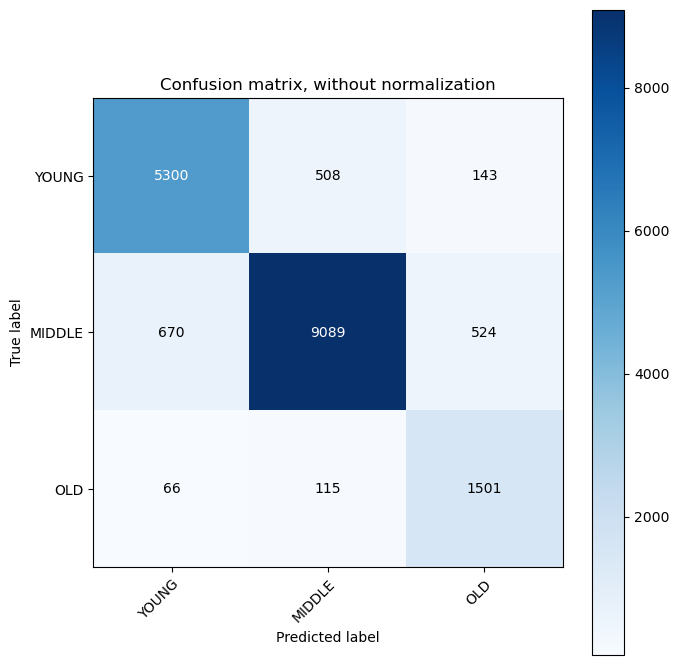

In [22]:
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

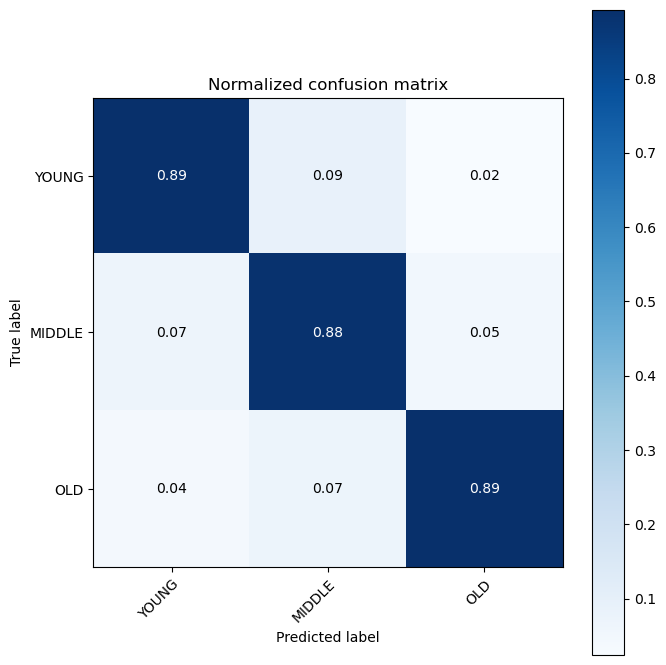

In [23]:
plot_confusion_matrix(y_labels, test_response, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')